In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches

# Orientations

We are interested in representing the orientation of crystals in 3D.

## Rotation and orientation matrix

A rotation matrix, when multiplied by a vector, results in the same vector rotated. An orientation matrix, when multiplied by a vector, results in the same vector in the rotated coordinate system. The orientation matrix (*passive rotation*) is the transpose of the corresponding rotation matrix (*active rotation*).

It is trivial to define rotation or orientation matrices which express rotations in a plane. For example, we will calculate the rotation matrices for rotations of 15, 30 and 60 degrees around the Z and X axes. First, we need the angles in radians:

In [2]:
def rad(a): return (a*np.pi)/180
ang=rad(np.array([15,30,60,75])) # rotation angle: 60 degrees
print(ang)

[0.26179939 0.52359878 1.04719755 1.30899694]


To find the rotation matrices, we take into account that the vector component parallel to the rotation axis must remain unchanged. The other components get multiplied by the sine or the cosine. Examples:

In [3]:
def trans1(a):
    s=list(range(len(a.shape)))
    return np.transpose(a,s[2:]+s[:2])
# Rotation around axis Z (in the XY plane) with angle a in radians
def rot_z(a):
    c,s=np.cos(a),np.sin(a)
    u=1.*(a==a); z=0.*u
    return trans1(np.array([[c,-s,z],[s,c,z],[z,z,u]]))
rz=rot_z(ang)
print(rz)

[[[ 0.96592583 -0.25881905  0.        ]
  [ 0.25881905  0.96592583  0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.8660254  -0.5         0.        ]
  [ 0.5         0.8660254   0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.5        -0.8660254   0.        ]
  [ 0.8660254   0.5         0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.25881905 -0.96592583  0.        ]
  [ 0.96592583  0.25881905  0.        ]
  [ 0.          0.          1.        ]]]


In [4]:
# Rotation around axis X (in the YZ plane) with angle a in radians
def rot_x(a):
    c,s=np.cos(a),np.sin(a)
    u=1.*(a==a); z=0.*u
    return trans1(np.array([[u,z,z],[z,c,-s],[z,s,c]]))
rx=rot_x(ang)
print(rx)

[[[ 1.          0.          0.        ]
  [ 0.          0.96592583 -0.25881905]
  [ 0.          0.25881905  0.96592583]]

 [[ 1.          0.          0.        ]
  [ 0.          0.8660254  -0.5       ]
  [ 0.          0.5         0.8660254 ]]

 [[ 1.          0.          0.        ]
  [ 0.          0.5        -0.8660254 ]
  [ 0.          0.8660254   0.5       ]]

 [[ 1.          0.          0.        ]
  [ 0.          0.25881905 -0.96592583]
  [ 0.          0.96592583  0.25881905]]]


Notice that, when we build the array with `np.array`, we get an array of shape `(3,3,n)`, where `n` is the number of angles. So, we need to transpose the matrix. But, when transposing the matrix, we do not want to transpose each of the rotation matrices, so we use the `trans1` function which reshapes an array of shape `(a,b,c)` into `(c,a,b)` and, for 2D arrays, leaves `(a,b)` as `(a,b)`.

Transformation (or orientation) matrices are obtained transposing the rotation matrices.

In [5]:
def trans2(a):
    s=list(range(len(a.shape)))
    return np.transpose(a,s[:-2]+s[-1:-3:-1])
tz=trans2(rz)
tx=trans2(rx)
print(tz)
print(tx)

[[[ 0.96592583  0.25881905  0.        ]
  [-0.25881905  0.96592583  0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.8660254   0.5         0.        ]
  [-0.5         0.8660254   0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.5         0.8660254   0.        ]
  [-0.8660254   0.5         0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.25881905  0.96592583  0.        ]
  [-0.96592583  0.25881905  0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          0.96592583  0.25881905]
  [ 0.         -0.25881905  0.96592583]]

 [[ 1.          0.          0.        ]
  [ 0.          0.8660254   0.5       ]
  [ 0.         -0.5         0.8660254 ]]

 [[ 1.          0.          0.        ]
  [ 0.          0.5         0.8660254 ]
  [ 0.         -0.8660254   0.5       ]]

 [[ 1.          0.          0.        ]
  [ 0.          0.25881905  0.96592583]
  [ 0.         -0.96592583  0.25881905]]]


Now, we want to transpose the actual rotation matrices, so we use the `trans2` function, which reshapes arrays with shape `(a,b,c)` into `(a,c,b)` or, for 2D arrays, `(a,b)` into `(b,a)`.

It is useful to check that the properties of rotation matrices are fulfilled using 90 degrees rotations:

In [6]:
def test_Rzx():
    rz,rx=rot_z(np.pi/2),rot_x(np.pi/2)
    assert((1,1)==(np.linalg.det(rz),np.linalg.det(rx)))              # matrix determinant == 1
    assert(np.isclose(np.identity(3),rz@np.transpose(rz)).all())      # matrix transpose == matrix inverse
    assert(np.isclose(np.identity(3),rx@np.transpose(rx)).all())
    assert(np.isclose(np.array([[0,-1,0],[1,0,0],[0,0,1]]),rz).all()) # matrix columns == rotated base vectors
    assert(np.isclose(np.array([[1,0,0],[0,0,-1],[0,1,0]]),rx).all())
test_Rzx()

## Euler angles

A triplet of Euler angles $(\varphi_1,\Phi,\varphi_2)$ represents an orientation corresponding to three successive rotations with respect to a reference position. The first orientation is performed around the Z axis with an angle $\varphi_1$. This results in the rotation of the axes X and Y, which will become X' and Y'. Next, a rotation with an angle $\Phi$ is performed around the axis X', resulting in the rotation of the axes Y' and Z, which become Y'' and Z'. Finally, a rotation with angle $\varphi_2$ is performed around the axis Z'.

With three Euler angles, we can describe any orientation in 3D. However, an orientation can be represented by more than one set of Euler angles. As a trivial example, any two triplets of Euler angles for which $\Phi$ is $0$ and $\varphi_1+\varphi_2$ is constant will represent the same orientation.

### Orientation matrix from Euler angles

The functions `rot_z` and `rot_x` previously defined can be used to define rotations around the Z and X axes. Moreover, rotations can be combined simply multiplying the corresponding matrices. Finally, we can convert a rotation matrix into an orientation matrix just transposing it. If we put everything together in a function, this function will return the orientation matrices corresponding to a list of triplets of Euler angles:

In [7]:
def rot(ea):
    phi1,Phi,phi2=np.transpose(ea)
    r=rot_z(phi2)@rot_x(Phi)@rot_z(phi1)
    return trans2(r)
ea=np.array([rad(np.array(a)) for a in [[30,0,0],[0,30,0],[15,30,45],[5,5,5]]])
r=rot(ea)
print(r)

[[[ 0.8660254   0.5         0.        ]
  [-0.5         0.8660254   0.        ]
  [ 0.          0.          1.        ]]

 [[ 1.          0.          0.        ]
  [ 0.          0.8660254   0.5       ]
  [ 0.         -0.5         0.8660254 ]]

 [[ 0.52451905  0.84150635  0.12940952]
  [-0.77451905  0.40849365  0.48296291]
  [ 0.35355339 -0.35355339  0.8660254 ]]

 [[ 0.98483666  0.17331779  0.00759612]
  [-0.17331779  0.98103136  0.08682409]
  [ 0.00759612 -0.08682409  0.9961947 ]]]


## Axis and angle

To calculate the angles of rotation we take into account that the trace of the rotation (or orientation) matrix, for an angle of rotation $\theta$, must be equal to $1+2\cos(\theta)$. Therefore, to get the angles in degrees from the rotation matrices:

In [8]:
def ang(r): return np.arccos((np.trace(r,axis1=-2,axis2=-1)-1)/2.)
def deg(a): return (a*180)/np.pi
print(deg(ang(r)))

[30.         30.         66.45188441 11.17749962]


[To find the axes](https://en.wikipedia.org/wiki/Rotation_matrix#Determining_the_axis), we take into account that, for each rotation, rotating the vector that represents the axis must result in the same vector. This is equivalent to say that the skew-symmetric part of the rotation matrix (obtained as $1/2(R-R^T)$) corresponds to the components of the axis. We then use `norm` to normalize the obtained normal vectors.

In [9]:
def norm(v):
    n=(v*v).sum(axis=-1)
    n=np.where(n==0,1,n)
    return np.transpose(np.transpose(v)/n**0.5)
def axis(r):
    s=list(range(len(r.shape)))
    r=np.transpose(r-trans2(r),s[-2:]+s[:-2])
    return norm(np.transpose([r[1,2],r[2,0],r[0,1]]))
print(axis(r))

[[0.         0.         1.        ]
 [1.         0.         0.        ]
 [0.45625264 0.12225253 0.88141242]
 [0.44789522 0.         0.89408606]]


**TODO** Calculate [rotation matrix from axis-angle](https://en.wikipedia.org/wiki/Rotation_matrix#Rotation_matrix_from_axis_and_angle)

## Miller indices

To represent orientations using Miller indices we need a plane (its normal direction) and a direction in that plane.

The orientation matrix and the corresponding Miller indices are easily correlated. The leftmost column is the normal to the plane, the rightmost column the direction. Both are perpendicular, and the third unitary vector must be perpendicular to both, so it is obtained using the vector cross product (see: [Texture Components and Euler Angles](http://pajarito.materials.cmu.edu/lectures/Components_EulerAngles-14Jan20.pdf)). We also normalize the vectors so that they are unitary. They should already be, but this way we mitigate any rounding error.

In [10]:
def miller(r):
    return norm(r[:,2]),norm(r[:,0])
hkl,uvw=miller(r)
print(hkl)
print(uvw)

[[ 0.          0.          1.        ]
 [ 0.         -0.5         0.8660254 ]
 [ 0.35355339 -0.35355339  0.8660254 ]
 [ 0.00759612 -0.08682409  0.9961947 ]]
[[0.8660254  0.5        0.        ]
 [1.         0.         0.        ]
 [0.52451905 0.84150635 0.12940952]
 [0.98483666 0.17331779 0.00759612]]


Using this relationship, we can also find the rotation matrix from the Miller indices. We only need to normalize the normal and direction vectors and calculate their dot product. Additionally, we check that the direction must be on the plane (must be perpendicular to the plane normal).

In [11]:
#def norm(v): return v/(v*v).sum()**0.5
def Rmiller(hkl,uvw):
    assert(0==np.dot(hkl,uvw)) # must be perpendicular
    n,d=norm(np.array(hkl)),norm(np.array(uvw))
    c=norm(np.cross(n,d))
    return np.array([d,c,n])
m=Rmiller([1,1,0],[0,0,1])
print(m)

[[ 0.          0.          1.        ]
 [ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.        ]]


# Symmetry

Crystals usually present some form of symmetry. What this means is that they are invariant to certain rotations. For example, a cubic crystal structure (or any cube, for that matter) will present 24 equivalent orientations.

#### Example

If we can visualize three faces of a Rubik cube, we will see three different colors. Performing 90 degrees rotations around the faces of the cube, we can change these three colors. There will be a total of 24 different combinations of colors, which will correspond to the 24 equivalent orientations of cubic symmetry.

## Symmetry operators

### Cubic symmetry

There are different ways in which we can represent the symmetry operators corresponding to cubic symmetry. Eventually, what we want are 24 orientation matrices.

For example, using Miller indices, we can define the operators as the orientations corresponding to orienting each of the 6 faces of the cube parallel to the 001 direction and then considering, for each one, four perpendicular directions.

In [12]:
cubic=[
    # face 001 perpendicular to 001
    Rmiller([0,0,1],[1,0,0]),Rmiller([0,0,1],[0,1,0]),Rmiller([0,0,1],[-1,0,0]),Rmiller([0,0,1],[0,-1,0]),
    # face 010 perpendicular to 001
    Rmiller([0,1,0],[1,0,0]),Rmiller([0,1,0],[0,0,1]),Rmiller([0,1,0],[-1,0,0]),Rmiller([0,1,0],[0,0,-1]),
    # face 100 perpendicular to 001
    Rmiller([1,0,0],[0,0,1]),Rmiller([1,0,0],[0,1,0]),Rmiller([1,0,0],[0,0,-1]),Rmiller([1,0,0],[0,-1,0]),
    # face -001 perpendicular to 001
    Rmiller([0,0,-1],[1,0,0]),Rmiller([0,0,-1],[0,1,0]),Rmiller([0,0,-1],[-1,0,0]),Rmiller([0,0,-1],[0,-1,0]),
    # face -010 perpendicular to 001
    Rmiller([0,-1,0],[1,0,0]),Rmiller([0,-1,0],[0,0,1]),Rmiller([0,-1,0],[-1,0,0]),Rmiller([0,-1,0],[0,0,-1]),
    # face -100 perpendicular to 001
    Rmiller([-1,0,0],[0,0,1]),Rmiller([-1,0,0],[0,1,0]),Rmiller([-1,0,0],[0,0,-1]),Rmiller([-1,0,0],[0,-1,0])
]
for c in cubic: print(c)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.  1.  0.]
 [-1.  0.  0.]
 [ 0.  0.  1.]]
[[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]]
[[ 0. -1.  0.]
 [ 1.  0. -0.]
 [ 0.  0.  1.]]
[[ 1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[-1.  0.  0.]
 [ 0. -0.  1.]
 [ 0.  1.  0.]]
[[ 0.  0. -1.]
 [-1.  0.  0.]
 [ 0.  1.  0.]]
[[ 0.  0.  1.]
 [ 0. -1.  0.]
 [ 1.  0.  0.]]
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[[ 0.  0. -1.]
 [-0.  1.  0.]
 [ 1.  0.  0.]]
[[ 0. -1.  0.]
 [ 0.  0. -1.]
 [ 1.  0.  0.]]
[[ 1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]
[[ 0.  1.  0.]
 [ 1. -0.  0.]
 [ 0.  0. -1.]]
[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]
[[ 0. -1.  0.]
 [-1. -0. -0.]
 [ 0.  0. -1.]]
[[ 1.  0.  0.]
 [-0.  0.  1.]
 [ 0. -1.  0.]]
[[ 0.  0.  1.]
 [-1.  0.  0.]
 [ 0. -1.  0.]]
[[-1.  0.  0.]
 [-0. -0. -1.]
 [ 0. -1.  0.]]
[[ 0.  0. -1.]
 [ 1.  0.  0.]
 [ 0. -1.  0.]]
[[ 0.  0.  1.]
 [ 0.  1. -0.]
 [-1.  0.  0.]]
[[ 0.  1.  0.]
 [ 0.  0. -1.]
 [-1.  0.  0.]]
[[ 0.  0. -1.]


**TODO** Calculate cubic symmetry operators using Euler angles and axis-angle.

### Tetragonal symmetry

### Hexagonal symmetry

### Orthorhombic symmetry

**TODO**

## Symmetric variants

Given an orientation (represented, for example, by an orientation matrix), we can obtain all the symmetric variants corresponding to that orientation applying each of the symmetry operators. These variants represent all the different orientations that correspond to the same orientation under symmetry.

For example, we can obtain the 24 variants of `r` multiplying it by each of the 24 cubic symmetry operators in `cubic`:

In [13]:
v=[c@r for c in cubic]
print(v[0])  # first variant of the 4 orientations
print(v[12]) # twelveth variant of the 4 orientations

[[[ 0.8660254   0.5         0.        ]
  [-0.5         0.8660254   0.        ]
  [ 0.          0.          1.        ]]

 [[ 1.          0.          0.        ]
  [ 0.          0.8660254   0.5       ]
  [ 0.         -0.5         0.8660254 ]]

 [[ 0.52451905  0.84150635  0.12940952]
  [-0.77451905  0.40849365  0.48296291]
  [ 0.35355339 -0.35355339  0.8660254 ]]

 [[ 0.98483666  0.17331779  0.00759612]
  [-0.17331779  0.98103136  0.08682409]
  [ 0.00759612 -0.08682409  0.9961947 ]]]
[[[ 0.8660254   0.5         0.        ]
  [ 0.5        -0.8660254   0.        ]
  [ 0.          0.         -1.        ]]

 [[ 1.          0.          0.        ]
  [ 0.         -0.8660254  -0.5       ]
  [ 0.          0.5        -0.8660254 ]]

 [[ 0.52451905  0.84150635  0.12940952]
  [ 0.77451905 -0.40849365 -0.48296291]
  [-0.35355339  0.35355339 -0.8660254 ]]

 [[ 0.98483666  0.17331779  0.00759612]
  [ 0.17331779 -0.98103136 -0.08682409]
  [-0.00759612  0.08682409 -0.9961947 ]]]


# Misorientations

The misorientation between two orientations is the rotation that converts one orientation into the other. If these orientations are subjected to some kind of symmetry, all the symmetric variants must be considered, and the one for the lowest misorientation angle (also called *disorientation*) will be the misorientation under symmetry.

## Relative rotation

If symmetry is not considered, and we want to calculate the misorientation between the orientations $R_1$ and $R_2$, the relative rotation $\Delta R$ will transform $R_1$ into $R_2$, so $R_2=\Delta R\,R_1$ and, therefore, $\Delta R=R_2\,R_1^{-1}=R_2\,R_1^T$. We can, for instance, calculate the relative rotation between `m` and each of the four orientations in `r`:

In [14]:
def dRot(r,s):
    return r@trans2(s)
dr=dRot(m,r)
print(dr)

[[[ 0.          0.          1.        ]
  [ 0.25881905 -0.96592583  0.        ]
  [ 0.96592583  0.25881905  0.        ]]

 [[ 0.          0.5         0.8660254 ]
  [ 0.70710678 -0.61237244  0.35355339]
  [ 0.70710678  0.61237244 -0.35355339]]

 [[ 0.12940952  0.48296291  0.8660254 ]
  [-0.22414387 -0.8365163   0.5       ]
  [ 0.96592583 -0.25881905  0.        ]]

 [[ 0.00759612  0.08682409  0.9961947 ]
  [ 0.5738305  -0.81624811  0.06676517]
  [ 0.81893886  0.57113974 -0.05602263]]]


## Axis and angle

The axes and angles of rotation can be obtained from the matrix using the functions previously defined.

In [15]:
print(deg(ang(dr)))
print(axis(dr))

[169.40858887 169.40858887 148.60028519 158.80214   ]
[[-0.70406259 -0.0926916  -0.70406259]
 [-0.70406259 -0.43230458 -0.56339029]
 [ 0.72822572  0.09587274  0.67859834]
 [-0.69744036 -0.24510628 -0.67342397]]


## Crystal symmetry

Under crystal symmetry, we will need to check all the possible variants. Alternatively, we can directly apply the symmetry operators to the relative matrix. We will choose as misorientation the one for which the disorientation (or misorientation angle) is minimum.

When we have two sets of orientations, we will be interested in the misorientation between all possible pairs of orientations.

In [16]:
def misorientations(csym,r1,r2):
    # returns disorientation angle in radians and axis
    # len(r1) 4 and len(r2) 5
    d=[]
    for ri,rj in itertools.product(r1,r2):
        d.append(dRot(ri,rj))
    # len(d) 4x5
    # d.shape (20,3,3)
    p=[]
    for s,di in itertools.product(csym,d):
        p.append(s@di)
    # len(csym) 24 => len(p)=24x4x5
    # p.shape (24x20,3,3)
    p=np.array(p).reshape(len(csym),len(d),3,3)
    # shape(p) (24,20,3,3)
    a=ang(p)
    # a.shape (24,20)
    m=a.argmin(axis=0)
    # m.shape (20)
    i,s=(m,range(len(m))),(len(r1),len(r2))
    # m=[9,3,14,22,...]
    # range(len(m))=[0,1,2,..,23]
    # i=([9,3,14,...],[0,1,2,...,23])
    # s=(4,5)
    return a[i].reshape(s),axis(p[i]).reshape(s+(3,))
# misorientations between two sets of orientations
r1=rot(np.array([rad(np.array(a)) for a in [[30,0,0],[0,30,0],[15,30,45],[5,5,5]]]))
r2=rot(np.array([rad(np.array(a)) for a in [[15,0,0],[30,0,0],[15,45,45],[5,5,0],[5,15,10]]]))
d,a=misorientations(cubic,r1,r2)
print(deg(d))
print(a)
# (uncorrelated) misorientations for a set of orientations
d,a=misorientations(cubic,r1,r1)
print(deg(d))
print(a)

[[15.          0.         51.25646522 25.4872919  21.18282227]
 [33.46386313 42.18116236 48.56909738 25.4872919  21.02208029]
 [53.64743528 42.18116236 15.         44.49532212 46.8023782 ]
 [ 7.06994558 20.60935717 57.74825022  5.         11.17749962]]
[[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 8.33290968e-01 -3.90913138e-01 -3.90913138e-01]
  [-1.88588272e-01  5.94616538e-02  9.80254444e-01]
  [-6.93304816e-01  1.53701977e-01  7.04062592e-01]]

 [[ 8.91316118e-01 -1.17343993e-01 -4.37933744e-01]
  [ 6.94746591e-01 -1.86156788e-01 -6.94746591e-01]
  [-6.27893211e-01 -1.12208864e-01  7.70168349e-01]
  [ 9.80254444e-01 -4.27988333e-02 -1.93053061e-01]
  [ 7.04129992e-01 -2.13748801e-01 -6.77135441e-01]]

 [[ 5.68657118e-01  7.48651299e-02  8.19160725e-01]
  [ 7.19254597e-01  4.13351104e-17  6.94746591e-01]
  [-9.65925826e-01  2.58819045e-01  8.71319388e-17]
  [ 2.58303870e-01  5.51909031e-01 -7.92890618e-01]
  [ 3.58983609e

# Stereographic projection

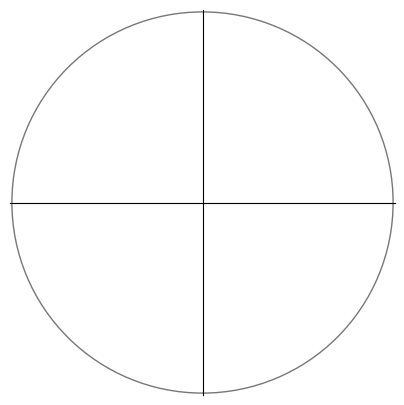

In [17]:
def circle1(size):
    plt.figure(figsize=(size,size))
    ax = plt.gca()
    # Make the circle patch and add to the figure
    circle = plt.Circle((0, 0), 1, color='#777', fill=None)
    ax.add_patch(circle)   
    # Make it a perfect circle by making it a perfect square box
    ax.set_aspect('equal', adjustable='box')
    # Set axis so it's visible 
    plt.xlim([-1.01,1.01])  
    plt.ylim([-1.01,1.01])
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xticks([])
    ax.set_yticks([])
circle1(5)

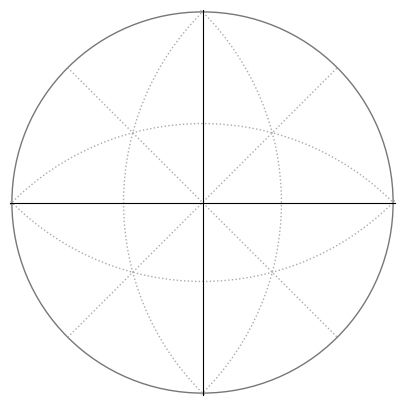

In [18]:
def arcs1(size):
    circle1(size)
    sq = 2.**0.5; sq2 = 2.*sq; sqh = 0.5*sq
    col = '#aaa'; ls = ':'
    def Arc(x, y, a):
        return matplotlib.patches.Arc((x,y), sq2, sq2, a, 0, 180, color=col, linestyle=ls)
    arcs = [
        Arc(0, -1, 0),
        Arc(0,  1, 180),
        Arc( 1, 0, 90),
        Arc(-1, 0, 270)
    ]
    ax = plt.gca()
    for a in arcs: ax.add_patch(a)
    x1, y1 = [-sqh,sqh], [-sqh,sqh]
    x2, y2 = [-sqh,sqh], [sqh,-sqh]
    plt.plot(x1, y1, x2, y2, linewidth=1, color=col, linestyle=ls)
arcs1(5)

In [19]:
def stereo(r,size=3,color='r'):
    n = r[:,:,-1]
    n = (np.abs(n[:,2:])<1)*n
    xy = n[:,:2]/(1-n[:,2:])
    yx = -n[:,:2]/(1+n[:,2:])
    m = (xy*xy).sum(axis=1)
    xy = np.where(np.transpose([m,m])<=1,xy,yx)
    arcs1(size)
    if isinstance(color, np.ndarray):
        cmap = plt.cm.rainbow
        norm = matplotlib.colors.Normalize(vmin=np.min(color), vmax=np.max(color))
        color = cmap(norm(color))
    plt.scatter(xy[:,0], xy[:,1], color=color, marker='o')
    plt.show()
    plt.close()

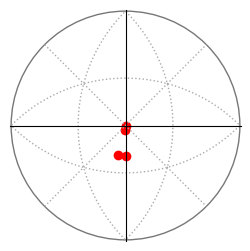

In [20]:
stereo(r)

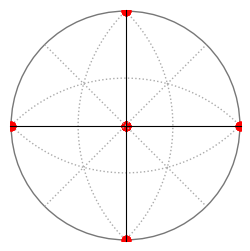

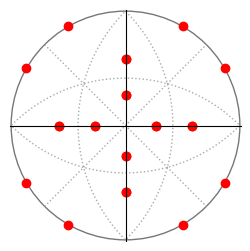

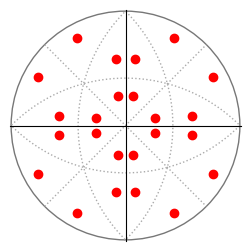

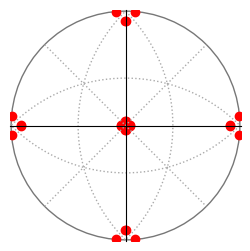

In [21]:
a = np.array(v)
for i in range(a.shape[1]):
    stereo(a[:,i])

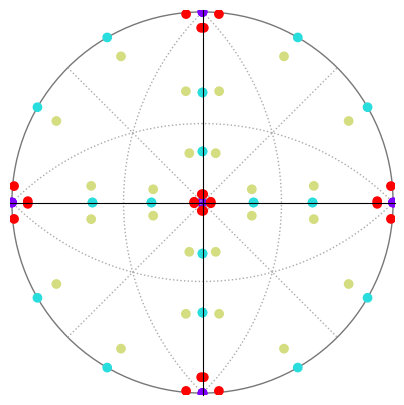

In [22]:
a = np.array(v).transpose([1,0,2,3])
ar = a.reshape((a.shape[0]*a.shape[1],a.shape[2],a.shape[3]))
ac = np.repeat(range(a.shape[0]),a.shape[1])
stereo(ar,color=ac,size=5)

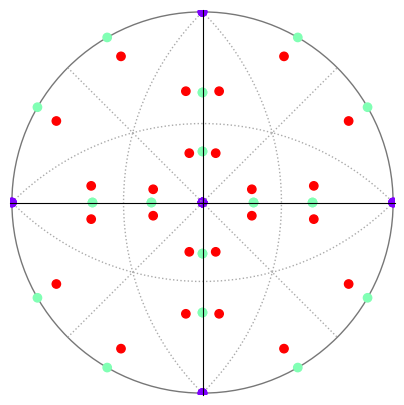

In [23]:
stereo(ar[:3*a.shape[1]],color=ac[:3*a.shape[1]],size=5)

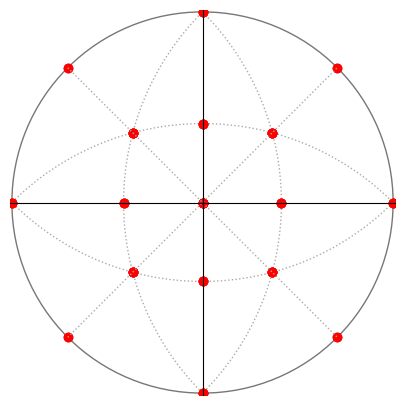

In [24]:
ea=np.array([rad(np.array(a)) for a in [[30,0,0],[0,45,0],[45,54.7,0]]])
r=rot(ea)
v=[c@r for c in cubic]
a = np.array(v).transpose([1,0,2,3])
ar = a.reshape((a.shape[0]*a.shape[1],a.shape[2],a.shape[3]))
stereo(ar[:3*a.shape[1]],size=5)